In [7]:
#Code inspired by https://www.kaggle.com/code/helmehelmuto/secondary-structure-prediction-with-keras
#Dataset from https://www.kaggle.com/aashita/secondary-structure-of-protein-data-set
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.utils import  to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

(393732, 7)


C:\Users\Ander\AppData\Local\Temp\ipykernel_17520\388205854.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])


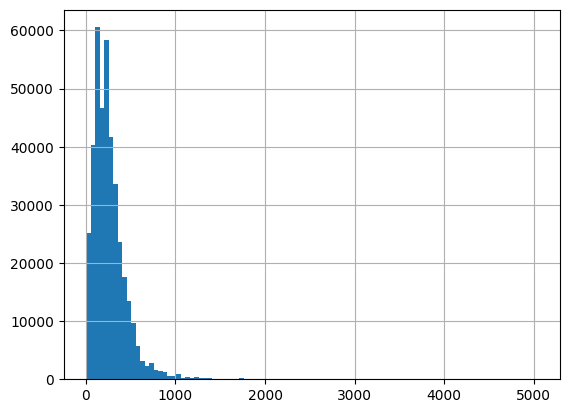

In [8]:
#Load the data
data = pd.read_csv('./Data/2018-06-06-ss.cleaned.csv')
max_length = 128
print(data.shape)

#Remove sequences that are too long and sequences that contain non-standard amino acids
sequences, structures = data[['seq', 'sst3']][(data.len <= max_length) & (~data.has_nonstd_aa)].values.T 

#For saving memory
data = []

#Making the sequences into grams, because this makes it easier for the model to learn
def seq_2n_grams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

sequences = seq_2n_grams(sequences)


In [9]:
#Preprocess the data, to fit into the model

#Encode the sequences with padding
#This is important because the sequences are not all the same length, which
#they need to be for the model to work
tokenizer_seq = Tokenizer()
tokenizer_seq.fit_on_texts(sequences)
sequences = tokenizer_seq.texts_to_sequences(sequences)
sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

print(sequences[1])

#Encode the structures, and categorize them
tokenizer_struc = Tokenizer(char_level=True)
tokenizer_struc.fit_on_texts(structures)
structures = tokenizer_struc.texts_to_sequences(structures)
structures = pad_sequences(structures, maxlen=max_length, padding='post')
structures = to_categorical(structures)

print(structures[1])

[ 957 3968    1    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
kck ck k
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 

((26655, 64, 4), (26655, 64))

In [10]:
#Finding the amount of words and tags, so we can use it in the model, with the correct dimensions
input_dimention = len(tokenizer_seq.word_index) + 1
tags = len(tokenizer_struc.word_index) + 1

# Define the model architecture
# Bidirectional LSTM is used because it is good for classifying sequences
model = Sequential()
model.add(Embedding(input_dim = input_dimention, output_dim= 128, input_length=max_length))
model.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Dense(tags, activation='softmax'))
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, structures, test_size=0.3, random_state=42)

# Train and save the model
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), verbose=1)

# Uncomment this line to save the model
#model.save("protein_model_smalldatasize.h5")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 128)           1069696   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64, 128)          98816     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 64, 4)             516       
                                                                 
Total params: 1,267,844
Trainable params: 1,267,844
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
146/146 [========================

In [11]:
# Evaluate the model on the test data
eval = model.evaluate(X_test, y_test, verbose=0)
print("test loss:", eval[0])
print("accuracy: ", eval[1])

#Best model so far (protein_model2.h5) had 0.17 loss and 0.93 accuracy
#That is the model used in the application

test loss: 0.16828523576259613
accuracy:  0.9426308274269104
